To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

# Setup

In [3]:
%matplotlib notebook
from matplotlib import pylab as plt
import os, sys

In [4]:
# Ensure the notebook is running in the proper directory
# (only needed when compiling from sphinx)
if "docs/source/tutorials" in os.getcwd():
    os.chdir("../../../examples")
sys.path.insert(0,"../build/")

In [5]:
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
#import pandas
import scipy
import json

from rascal.representations import SphericalInvariants as SOAP

In [6]:
import sklearn

In [245]:
from scipy.special import gamma, gammainc

# Basis functions
# Currently we only have implemented:
# - GTO with Constant sigma on
# - DVR with ???
# for now only GTO is supported for tests
def basis_function(radial_basis="GTO", gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4):
    if radial_basis == "GTO":
        return gto_basis_function(gaussian_sigma_type, gaussian_sigma_constant)
    else:
        raise NotImplementedError("The only supported basis function is GTO at the moment")
# R^{GTO}_{n}(r) = \mathcal{N}_n\ r^{n} \exp[-br^2]
def gto_basis_function(gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4):
    if gaussian_sigma_type == "Constant":
        return gto_basis_constant_function(sigma=gaussian_sigma_constant)
    else:
        raise NotImplementedError("The only supported gaussian sigma type is Constant at the moment")


# \mathcal{N}_n^2 = \frac{2}{\sigma_n^{2n + 3}\Gamma(n + 3/2)}.
def gaussian_sigma_constant_coeffs(cutoff, n, max_n):
    sigma = np.sqrt(n) * cutoff / max_n
    b = 1/(2*sigma**2)
    # not working
    # from doc
    #N = np.sqrt( 2/((sigma)**(2*n+3) *gamma(n+3/2)) )    
    # from rascal c++
    #N = 0.25 * np.sqrt( 2/((sigma)**(2*n+3) *gamma(n+1.5)) )    
    # from wolfram alpha
    N = 1/( np.sqrt(2**(n+1)) * sigma**(n+1) *gamma((n+1)/2) )
    return N, b
# R^{GTO}_{n}(r) = \mathcal{N}_n\ r^{n} \exp[-br^2]
def gaussian_sigma_constant(N, b, n, r):
    return N * r**n * np.exp(-b*r**2)

In [246]:
from scipy import integrate
#interaction_cutoff
def integrate_env(bf, interaction_cutoff):    
    return integrate.quad(bf, -0.0001, interaction_cutoff)

(0.5, 3.1372510321344655e-12)


<IPython.core.display.Javascript object>


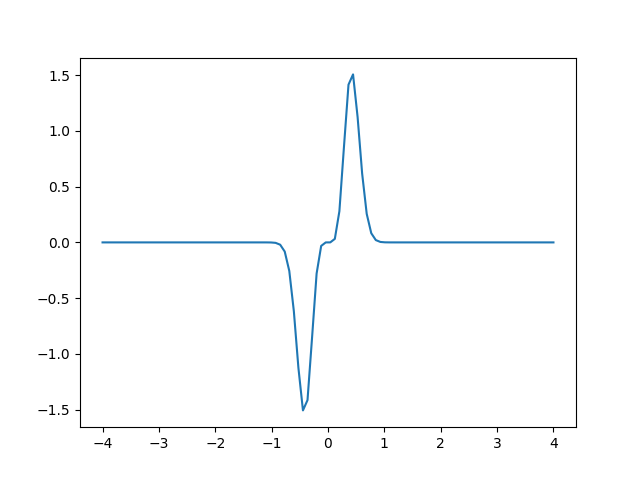

In [247]:
n = 5
max_n = 6
cutoff = 0.5
range_ = 4
N, b = gaussian_sigma_constant_coeffs(cutoff, n, max_n)
bf = lambda r : gaussian_sigma_constant(N, b, n, r)
print(integrate_env(bf, range_))

import matplotlib.pyplot as plt
x = np.linspace(-range_,range_,100)
plt.plot(x, bf(x))
plt.show()

In [244]:
radial_basis

def do_all(frame, radial_basis="GTO", gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4, max_radial=6, interaction_cutoff=3.5):
    hypers = dict(soap_type="RadialSpectrum",
                  interaction_cutoff=interaction_cutoff,
                  max_radial=max_radial, 
                  max_angular=0,
                  radial_basis=radial_basis
                  gaussian_sigma_constant=gaussian_sigma_constant,
                  gaussian_sigma_type=gaussian_sigma_type,
                  cutoff_smooth_width=0.5,
                  )
    soap = SOAP(**hypers)
    nb_envs, nb_coeffs  = representation.get_dense_feature_matrix(soap).shape
    nb_species = nb_coeffs/max_radial
    bf = basis_function(radial_basis, gaussian_sigma_type, gaussian_sigma_constant)
    integrate_env(bf, interaction_cutoff)

SyntaxError: invalid syntax (<ipython-input-244-1ca6332d94e2>, line 9)

## Download data

Run the cell below to dowload the CSD-500 dataset you'll need for this tutorial.

The data is from the paper "Chemical shifts in molecular solids by machine learning" by Paruzzo, Hofstetter, Musil, De, Ceriotti and Emsley, available [here](https://www.nature.com/articles/s41467-018-06972-x). (If the cell below doesn't work, try downloading "Supplementary Data 2" from the [supplementary info section](https://www.nature.com/articles/s41467-018-06972-x#Sec11) of the paper; be sure to name it `data/CSD-500.xyz` as below).

In [1]:
download_link = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06972-x/MediaObjects/41467_2018_6972_MOESM4_ESM.txt"
import urllib.request
urllib.request.urlretrieve(download_link, './data/CSD-500.xyz')

('./data/CSD-500.xyz', <http.client.HTTPMessage at 0x7f0da403a4a8>)

In [7]:
#frames = read('./data/small_molecules-1000.xyz',':600')
frames = read('./data/CSD-500.xyz',':3')

In [8]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames)

In [9]:
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])

In [10]:
chem_shifts[1].shape

(62, 2)

In [11]:
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)

In [12]:
chem_shifts_atoms.shape

(362, 2)

# SOAP: Power spectrum

In [50]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6,
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [51]:
%time representation = soap.transform(frames)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 9.77 ms


In [52]:
X = representation.get_dense_feature_matrix(soap).T

In [53]:
X.shape

(24, 362)

[{'name': 'centers', 'args': []},
 {'name': 'neighbourlist', 'args': {'cutoff': 3.5}},
 {'name': 'centercontribution', 'args': {}},
 {'name': 'strict', 'args': {'cutoff': 3.5}}]

# Learning the chemical shifts of a set of crystal structures

## learning utilities

In [ ]:
def compute_representation(representation, frames):
    result = representation.transform(frames)
    return result

#def compute_representation(frames):
#    expansions = soap.transform(frames)
#    return expansions

def compute_atomic_kernel(zeta, rep1, rep2=None):
    if rep2 is not None:
        kernel = rep1.cosine_kernel_atomic(rep2, zeta)
    else:
        kernel = rep1.cosine_kernel_atomic(zeta)
    return kernel

def extract_energy(frames):
    prop = [[]]*len(frames)
    for ii,cc in enumerate(frames):
        #prop[ii] = cc.info['dft_formation_energy_per_atom_in_eV']
        prop[ii] = cc.info['ENERGY']
    y = np.array(prop)
    return y

def split_dataset(frames, test_fraction, seed=10):
    N = len(frames)
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train = ids[:Ntrain]
    test = ids[Ntrain:]
    targets = extract_energy(frames)
    return [frames[ii] for ii in train],targets[train],[frames[ii] for ii in test],targets[test]

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)


score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

class KRR(object):
    def __init__(self,zeta,weights,representation,X):
        self.weights = weights
        self.representation = representation
        self.zeta = zeta
        self.X = X
        
    def predict(self,frames):
        features = compute_representation(self.representation,frames)
        kernel = compute_atomic_kernel(self.zeta, self.X, features)
        return np.dot(self.weights, kernel)

def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    features = compute_representation(representation, frames)
    kernel = compute_atomic_kernel(zeta, features, features)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation, features)
    return model,kernel


In [ ]:
compute_representation(soap, frames)

## With the full power spectrum

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=1, 
              max_angular=1, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
frames_train, y_train, frames_test, y_test = split_dataset(frames,0.5)

In [ ]:
y_train = np.concatenate([frame.arrays['CS'] for frame in frames_train], axis=0)

In [ ]:
y_train = y_train[:,0]

In [ ]:
y_test = np.concatenate([frame.arrays['CS'] for frame in frames_test], axis=0)

In [ ]:
y_test = y_test[:,0]

In [ ]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames_train)

In [ ]:
zeta = 2

In [ ]:
features = compute_representation(soap, frames_train)

In [ ]:
features

In [ ]:
kernel = compute_atomic_kernel(zeta, features, features)

In [ ]:
kernel.shape

In [ ]:
# WTF?
#for i in range(len(kernel)):
#    kernel[i][0] = np.sqrt(i)/50

In [ ]:
kernel[191]

In [ ]:
# First, try without regularization -- the results will be nonsense
weights = np.linalg.solve(kernel,y_train)

In [ ]:
weights.shape

In [ ]:
model = KRR(zeta, weights, soap, features)

In [ ]:
y_pred = model.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
zeta = 2
Lambda = 10
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [ ]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
#sc = plt.scatter(y_pred, y_test, s=3)
#ax = plt.axis('scaled')
plt.plot(y_test, y_pred, '.')
plt.ylabel('DFT shift')
plt.xlabel('Predicted shift')
plt.savefig('R1.png', dpi=300)

## With just the radial spectrum

In [43]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5
              )
soap = SOAP(**hypers)

In [44]:
frames_train, y_train, frames_test, y_testr = split_dataset(frames,0.4)

NameError: name 'split_dataset' is not defined

In [45]:
zeta = 2
Lambda = 5e-3
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

NameError: name 'train_krr_model' is not defined

In [ ]:
y_predr = krr.predict(frames_test)
get_score(y_predr, y_testr)

In [ ]:
#plt.scatter(y_predr, y_testr, s=3)
#plt.scatter(y_predr, y_testr, s=3)
#ax = plt.axis('scaled')
plt.plot(y_pred, y_test, '.b')
plt.plot(y_predr, y_testr, '.y')
plt.legend(['Full','Radial'])
plt.ylabel('DFT energy / (eV/atom)')
plt.xlabel('Predicted energy / (eV/atom)')
plt.savefig('R1.png', dpi=300)

# Make a map of the dataset

## utils

In [ ]:
def compute_representation(representation,frames):
    expansions = soap.transform(frames)
    return expansions

def compute_kernel(zeta, rep1, rep2=None):
    if rep2 is None:
        kernel = rep1.cosine_kernel_global(zeta)
    else:
        kernel = rep1.cosine_kernel_global(rep2,zeta)
    return kernel

In [ ]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")

## make a map with kernel pca projection

In [ ]:
# Load the small molecules 
frames = read('./data/small_molecules-1000.xyz',':600')

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
zeta = 2

features = compute_representation(soap, frames)

kernel = compute_kernel(zeta,features)

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(kernel)

In [ ]:
X = kpca.transform(kernel)

In [ ]:
plt.scatter(X[:,0],X[:,1],s=3)
#plt.savefig('PCA.png',dpi=300)

## make an interactive map

In [ ]:
# package to visualize the structures in the notebook
# https://github.com/arose/nglview#released-version
import nglview

In [ ]:
iwdg = nglview.show_asetraj(frames)
# set up the visualization
iwdg.add_unitcell()
iwdg.add_spacefill()
iwdg.remove_ball_and_stick()
iwdg.camera = 'orthographic'
iwdg.parameters = { "clipDist": 0 }
iwdg.center()
iwdg.update_spacefill(radiusType='covalent',
                                   scale=0.6,
                                   color_scheme='element')
iwdg._remote_call('setSize', target='Widget',
                               args=['%dpx' % (600,), '%dpx' % (400,)])
iwdg.player.delay = 200.0

In [ ]:
link_ngl_wdgt_to_ax_pos(plt.gca(), X, iwdg)
plt.scatter(X[:,0],X[:,1],s=3)
iwdg